# Target2: 10% in 5 days Classification
---

### Table of Contents:
1. Import data and create features and target variables
2. TrainTestSplit and Feature Scaling
3. Performance Definition
4. Model1: DecisionTreeClassifier
5. Model2: RandomForestClassifier
6. Model3: LogisticRegression
7. Model4: SVC
8. Model5: KNN
9. Model6: Dummy Classifier
9. Performance Comparisons

---

In [2]:
import pandas as pd
import numpy as np
import time, datetime
import math
import matplotlib.pyplot as plt

### 1. Import data and create features and target variables

In [4]:
import pandas_datareader as web

In [5]:
#List of stock tickers for data gathering
tickers = ['VBIV', 'AGRX', 'VXRT', 'JAGX', 'MNKD', 'OPK', 'IMGN']

In [6]:
#Set timeline for data
start_date = '2018-01-01'
end_date = datetime.date.today()

In [7]:
#The following function loads the data for each ticker and creates the features and target variables
#For more information about each feature see FeaturesEngineering.ipynb

def get_data(ticker):
    df = web.DataReader(ticker, data_source = 'yahoo', start = start_date, end = end_date)
    df = df.reset_index()
    df['Symbol'] = ticker
    
    df['Avg_Vol_20'] = -1
    for row in range(20, df.shape[0]):
        df.iloc[row, -1] = np.mean(df.iloc[row-20:row, df.columns.get_loc('Volume')])
    
    df['Vol_Ratio1'] = df['Volume'] / df['Avg_Vol_20']
    
    df['Open/Close'] = -1
    for row in range(1, df.shape[0]):
        df.iloc[row,-1] = df.iloc[row, df.columns.get_loc('Open')] / df.iloc[row-1, df.columns.get_loc('Close')]
    
    df['Low/Open'] = df['Low'] / df['Open']
    df['High/Open'] = df['High'] / df['Open']
    
    df['DailyLogReturn'] = -1
    for row in range(1, df.shape[0]):
        df.iloc[row, -1] = math.log(df.iloc[row, df.columns.get_loc('Close')] / df.iloc[row-1, df.columns.get_loc('Close')])

    df['SquaredDailyLogReturn'] = df['DailyLogReturn']**2
    
    df['SMA10'] = -1
    for row in range(10, df.shape[0]):
        df.iloc[row, -1] = np.average(df.iloc[row-10:row, df.columns.get_loc('Close')])
    
    df['SMA30'] = -1
    for row in range(30, df.shape[0]):
        df.iloc[row, -1] = np.average(df.iloc[row-30:row, df.columns.get_loc('Close')])
        
    df['SMA_Ratio'] = df['SMA30'] / df['SMA10']
    
    Smoothing = 2
    Days = 12
    df['EMA12'] = -1
    #The first observation of EMA will not a have a previous EMA so we will use a 12-day SMA
    df.iloc[12, -1] = (df.iloc[row, df.columns.get_loc('Close')] * Smoothing / (1 + Days)
                       + (np.average(df.iloc[0:12, df.columns.get_loc('Close')]) * (1 - (Smoothing / (1 + Days)))))

    #For the remaining observations, we will use the previous EMA as in the formula
    for row in range(13, df.shape[0]):
        df.iloc[row, -1] = (df.iloc[row, df.columns.get_loc('Close')] * Smoothing / (1 + Days)
                       + (df.iloc[row - 1, -1]) * (1 - (Smoothing / (1 + Days))))    
    
    df['StochasticOscillator'] = -1
    for row in range(13, df.shape[0]):
        df.iloc[row, -1] = ((df.iloc[row, df.columns.get_loc('Close')] - np.min(df.iloc[row-13:row+1, df.columns.get_loc('Low')]))
                            / (np.max(df.iloc[row-13:row+1, df.columns.get_loc('High')]) - np.min(df.iloc[row-13:row+1, df.columns.get_loc('Low')]))
                            * 100)
        
    #Target1: Binary- Up(1) or Down(0) movement, closing price to closing price
    df['Target1'] = -1
    for row in range(0, df.shape[0]-1):
        if df.iloc[row, df.columns.get_loc('Close')] < df.iloc[row+1, df.columns.get_loc('Close')]:
            df.iloc[row, -1] = 1
        else:
            df.iloc[row, -1] = 0
            
            
    #Target2: Binary: (1)Price increases by 10% withing 5 days, or not(0)
    df['Target2'] = -1
    for row in range(0, df.shape[0]-4):
        if df.iloc[row, df.columns.get_loc('Close')] * 1.1 < np.max(df.iloc[row+1:row+6, df.columns.get_loc('High')]):
            df.iloc[row, -1] = 1
        else:
            df.iloc[row, -1] = 0
            
            
    #Target3: Multiclassification: Next days movement
    df['Target3'] = -1
    for row in range(df.shape[0] - 1):
        current_close = df.iloc[row, df.columns.get_loc('Close')]
        next_close = df.iloc[row + 1, df.columns.get_loc('Close')]
        ratio = next_close / current_close

        if ratio <= 0.9:
            df.iloc[row, -1] = 1
        elif ratio <= 0.95:
            df.iloc[row, -1] = 2
        elif ratio <= 1:
            df.iloc[row, -1] = 3
        elif ratio <= 1.05:
            df.iloc[row, -1] = 4
        elif ratio <= 1.1:
            df.iloc[row, -1] = 5
        else:
            df.iloc[row, -1] = 6
        
    df = df[(df['Avg_Vol_20'] != -1) & (df['Open/Close'] != -1) & (df['SMA10'] != -1) & (df['SMA30'] != -1)
            & (df['EMA12'] != -1) & (df['StochasticOscillator'] != -1) & (df['Target1'] != -1)
            & (df['Target2'] != -1) & (df['Target3'] != -1)]
            
    return df 
    

In [9]:
#Run above function for each ticker and concatenate all dataframes into one master dataframe
start_time = time.time()

df = pd.DataFrame()

for ticker in tickers:
    sub_df = get_data(ticker)
    df = pd.concat([df, sub_df], ignore_index = True)
    
print(time.time() - start_time)

22.1629376411438


### Target2 Count

In [11]:
#View the count for binary classifier
count = df[['Target2', 'Symbol']].groupby('Target2').count()
count

,Symbol
Target2,
0,2700
1,1514


In [12]:
from collections import Counter

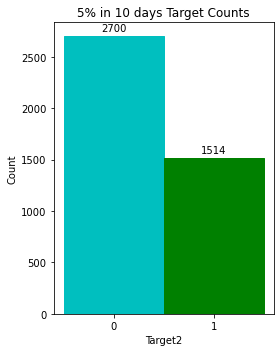

In [61]:
labels, values = zip(*Counter(list(df['Target2'])).items())

indexes = np.arange(len(labels))
width = 1

fig, ax = plt.subplots(figsize = (4,5))
rects = ax.bar(indexes, values, width, label = 'Target2')

#Labels
ax.set_ylabel('Count')
ax.set_xlabel('Target2')
ax.set_title('5% in 10 days Target Counts')
ax.set_xticks(indexes)
rects[0].set_color('c')
rects[1].set_color('g')

for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
               xy = (rect.get_x() + rect.get_width() / 2, height),
               xytext = (0, 3),
               textcoords = "offset points",
               ha = 'center', va = 'bottom')


fig.tight_layout()
    
plt.show()

### 2. TrainTestSplit and Feature Scaling

In [64]:
#Features list for training. Since there was no preprocessing when concatenating df for each ticker, only ratio features
#are valid for training.

#X_features = list(df.columns)[8:-3]
X_features = (['Vol_Ratio1',
             'Open/Close',
             'Low/Open',
             'High/Open',
             'DailyLogReturn',
             'SquaredDailyLogReturn',
             'SMA_Ratio',
             'StochasticOscillator'])
y_feature = 'Target2'

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y_feature], random_state = 0)

In [69]:
#Scaling
from sklearn.preprocessing import scale, MinMaxScaler

In [72]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit_transform(X_test)

### 3. Performance Metrics

In [73]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [170]:
def performance(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    
    print('Model train accuracy: %0.3f' % accuracy_score(y_train, y_pred_train))
    print('Model test accuracy: %0.3f' % accuracy_score(y_test, y_pred_test))
    
    
    
    #confusion matrix
    print('Confusion Matrix:')
    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)
    
    print('')
    #accuracy
    print('Accuracy score: ', accuracy_score(y_test, y_pred_test))
    
    print(' ')
    #recall score
    print('Recall score: ', recall_score(y_test, y_pred_test, zero_division = 0))
    
    print(' ')
    #precision score
    print('Precision score: ', precision_score(y_test, y_pred_test))
    
    
    return [accuracy_score(y_test, y_pred_test),
            recall_score(y_test, y_pred_test, zero_division = 0),
            precision_score(y_test, y_pred_test),
            cm[0][0] + cm[1][0],
            cm[0][1] + cm[1][1]]
            

### 4. Model1: DecisionTreeClassifier

In [75]:
from sklearn.tree import DecisionTreeClassifier

In [80]:
clf = DecisionTreeClassifier(random_state = 0)

In [81]:
model1 = clf.fit(X_train, y_train)

In [143]:
performance1 = performance(model1, X_train, X_test, y_train, y_test)

Model train accuracy: 1.000
Model test accuracy: 0.581
Confusion Matrix:
[[454 231]
 [211 158]]

Accuracy score:  0.5806451612903226
 
Recall score:  0.4281842818428184
 
Precision score:  0.40616966580976865


### 5. Model2: RandomForestClassifier

In [144]:
from sklearn.ensemble import RandomForestClassifier

In [145]:
model2 = RandomForestClassifier().fit(X_train, y_train)

In [146]:
performance2 = performance(model2, X_train, X_test, y_train, y_test)

Model train accuracy: 1.000
Model test accuracy: 0.648
Confusion Matrix:
[[589  96]
 [275  94]]

Accuracy score:  0.6480075901328273
 
Recall score:  0.25474254742547425
 
Precision score:  0.49473684210526314


###  6. Model3: LogisticRegression

In [147]:
from sklearn.linear_model import LogisticRegression

In [148]:
model3 = LogisticRegression().fit(X_train_scaled, y_train)

In [149]:
performance3 = performance(model3, X_train_scaled, X_test_scaled, y_train, y_test)

Model train accuracy: 0.643
Model test accuracy: 0.646
Confusion Matrix:
[[672  13]
 [360   9]]

Accuracy score:  0.6461100569259962
 
Recall score:  0.024390243902439025
 
Precision score:  0.4090909090909091


### 7. Model4: SVC 

In [150]:
from sklearn.svm import SVC

In [151]:
model4 = SVC().fit(X_train_scaled, y_train)

In [152]:
performance4 = performance(model4, X_train_scaled, X_test_scaled, y_train, y_test)

Model train accuracy: 0.641
Model test accuracy: 0.652
Confusion Matrix:
[[679   6]
 [361   8]]

Accuracy score:  0.6518026565464896
 
Recall score:  0.02168021680216802
 
Precision score:  0.5714285714285714


### 8. Model5: KNN

In [153]:
from sklearn.neighbors import KNeighborsClassifier

In [154]:
model5 = KNeighborsClassifier().fit(X_train_scaled, y_train)

In [155]:
performance5 = performance(model5, X_train_scaled, X_test_scaled, y_train, y_test)

Model train accuracy: 0.734
Model test accuracy: 0.591
Confusion Matrix:
[[521 164]
 [267 102]]

Accuracy score:  0.5910815939278937
 
Recall score:  0.2764227642276423
 
Precision score:  0.38345864661654133


### 9. Model6: Dummy Classifier

In [162]:
from sklearn.dummy import DummyClassifier

In [163]:
strategy = ['stratified', 'most_frequent', 'prior', 'uniform']

In [173]:
#Finding the best dummy (based on precision or 1's count)
best_dummy = [0, 0, 0, 0, 0]
for s in strategy:
    print('Strategy: %s' %s)
    model6 = DummyClassifier(strategy = s).fit(X_train, y_train)
    performance6 = performance(model6, X_train, X_test, y_train, y_test)
    if performance6[2] > best_dummy[2]:
        best_dummy = performance6
    print('\n')

Strategy: stratified
Model train accuracy: 0.535
Model test accuracy: 0.558
Confusion Matrix:
[[439 246]
 [220 149]]

Accuracy score:  0.5578747628083491
 
Recall score:  0.4037940379403794
 
Precision score:  0.37721518987341773


Strategy: most_frequent
Model train accuracy: 0.638
Model test accuracy: 0.650
Confusion Matrix:
[[685   0]
 [369   0]]

Accuracy score:  0.6499051233396584
 
Recall score:  0.0
 
Precision score:  0.0


Strategy: prior
Model train accuracy: 0.638
Model test accuracy: 0.650
Confusion Matrix:
[[685   0]
 [369   0]]

Accuracy score:  0.6499051233396584
 
Recall score:  0.0
 
Precision score:  0.0


Strategy: uniform
Model train accuracy: 0.497
Model test accuracy: 0.468
Confusion Matrix:
[[333 352]
 [209 160]]

Accuracy score:  0.46774193548387094
 
Recall score:  0.43360433604336046
 
Precision score:  0.3125




### 10. Model Performance Comparisons

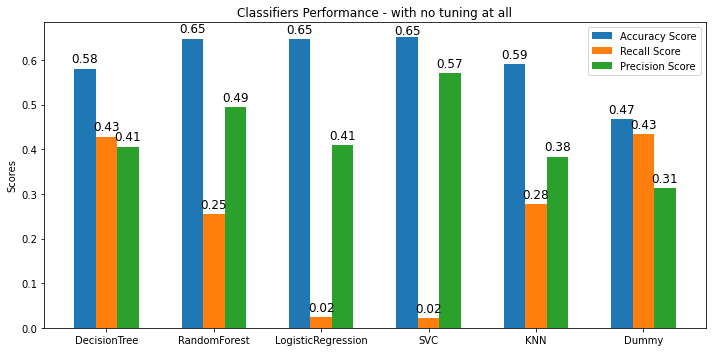

In [199]:
#Plot performance

labels = ['DecisionTree', 'RandomForest', 'LogisticRegression', 'SVC', 'KNN', 'Dummy']

i = 0
accuracy = [performance1[i], performance2[i], performance3[i], performance4[i], performance5[i], performance6[i]]
i = 1
recall = [performance1[i], performance2[i], performance3[i], performance4[i], performance5[i], performance6[i]]
i = 2
precision = [performance1[i], performance2[i], performance3[i], performance4[i], performance5[i], performance6[i]]


x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize = (10,5))
rects1 = ax.bar(x - width, accuracy, width, label = 'Accuracy Score')
rects2 = ax.bar(x, recall, width, label = 'Recall Score')
rects3 = ax.bar(x+width, precision, width, label = 'Precision Score')


ax.set_ylabel('Scores')
ax.set_title('Classifiers Performance - with no tuning at all')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 0)



def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        p_height = (height / y_height)

        if p_height > 0.95: 
            label_position = height
        else:
            label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2, label_position,
                '%.2f' % float(height),
                ha='center', va='bottom',color='k',fontsize=12)        
        
        
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)


fig.tight_layout()
plt.show()

#### Based on the above plot, it looks like SVC has the best Precision Scores so far but we also notice that SVC and LogisticRegression have really low Recall Scores which would suggest they are not predicting any 1's. So we should take a look at the actual prediction counts next.

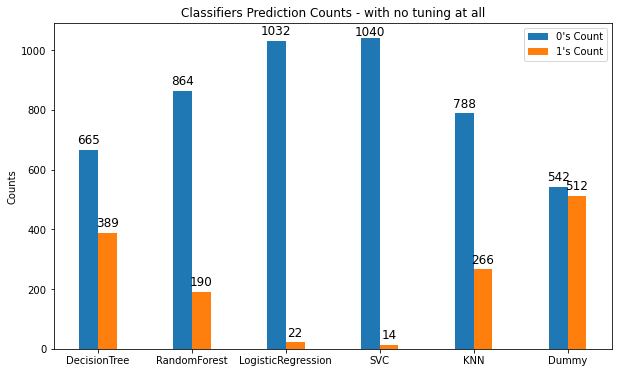

In [197]:
#Plot prediction (0,1) counts

labels = ['DecisionTree', 'RandomForest', 'LogisticRegression', 'SVC', 'KNN', 'Dummy']

i = 3
zeros = [performance1[i], performance2[i], performance3[i], performance4[i], performance5[i], performance6[i]]
i = 4
ones = [performance1[i], performance2[i], performance3[i], performance4[i], performance5[i], performance6[i]]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize = (10,6))
rects4 = ax.bar(x - width/2, zeros, width, label = "0's Count")
rects5 = ax.bar(x + width/2, ones, width, label = "1's Count")


ax.set_ylabel('Counts')
ax.set_title('Classifiers Prediction Counts - with no tuning at all')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 0)


def autolabel(rects, ax):
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        p_height = (height / y_height)

        if p_height > 0.95:
            label_position = height # - (y_height * 0.05)
        else:
            label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2, label_position,
                '%s' % str(height),
                ha='center', va='bottom',color='k',fontsize=12)  




autolabel(rects4, ax)
autolabel(rects5, ax)

#### Now we can see that although SVC seemed to have the best Precision Score, it has predicted the least 1's

#### This might be okay for my purposes at the moment, a few more would be nicer though.